Generate temperature, salinity, and nutrient initial files to use in MITgcm runs.

Functions to generate T, S, and nutrient initial conditions (profiles) for MITgcm
=========================================================================

Choose between linear profile and profile interpolated from Pthways Curise 2013 at Barkley Canyon data.
K. Ramos-Musalem

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import struct

%matplotlib inline

In [2]:
def iniTracer(xsize, ysize, IniDepth, IniProfile, InterpDepth):
    
    InterpProfile = np.interp(InterpDepth, IniDepth , IniProfile)
    
    tracer = np.zeros((xsize, ysize, len(InterpDepth)))
    
            
    for kk in np.arange(len(InterpDepth)):
        tracer[ii,jj,kk]=np.ones(ysize,xsize)*InterpProfile[kk] 
            

    return tracer

In [3]:
def iniTracerLin(xsize, ysize, TopVal,BotVal, Depth ):
    
    # Generate linear nutrient profile (i.e. C(Depth)= IniVal*Depth) 
    
    M = (BotVal-TopVal)/(Depth[len(Depth)-1]-Depth[0])
    b = (TopVal - M*Depth[0])*np.ones((len(Depth),1))
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    
    for kk in np.arange(len(Depth)):
        tracer[:,:,kk]=np.ones(ysize,xsize)*(M*Depth[kk]+b[kk]) 
            

    return tracer

In [19]:
def iniTracerStep(xsize, ysize, TopVal, BotVal, Hs, Depth):
    
    # Generate a step nutrient profile with TopVal the value on top of the step and BotVal below
    # (i.e. C(z)= TopVal for z > Zs) 
    #           = BotVal for z < Zs. 
    # Here z=0 is at the surface and increases downwards.
    # Hs is the depth of the step (positive)
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    print(np.shape(tracer))
    for kk in np.arange(len(Depth)):
        if Depth[kk] < Hs:
            tracer[:,:,kk]= np.ones((xsize,ysize))*TopVal
            print(Depth[kk],tracer[1,1,kk])
        else:
            tracer[:,:,kk]= np.ones((xsize,ysize))*BotVal
            print(Depth[kk],tracer[1,1,kk])

            

    return tracer

In [5]:
def iniTracerLinHor(xsize, zsize, TopVal,BotVal, yvec ):
    
    # Generate linear nutrient profile (i.e. C(yvec)= IniVal*yvec) 
    
    M = (BotVal-TopVal)/(yvec[len(yvec)-1]-yvec[0])
    b = (TopVal - M*yvec[0])*np.ones((len(yvec),1))
    
    tracer = np.zeros((xsize,len(yvec),zsize))
    
    for ii in np.arange(xsize):
        for jj in np.arange(zsize):
            for kk in np.arange(len(yvec)):
                tracer[ii,kk,jj]=M*yvec[kk]+b[kk] 
            

    return tracer

In [6]:
def iniTracerCnt(xsize, ysize, CntVal, Depth ):
    # Generate constant nutrient profile  
    
    tracer = np.ones((xsize, ysize, len(Depth)))
    tracer = tracer*CntVal
    

    return tracer

In [7]:
def iniTracerArctan(xsize, ysize, a, Hs, Csb, Depth ):
    '''
    This function generates an array of size (xsize x ysize x len(Depth)) of tracer concentration
    that changes vertically as C(z) = -1.5*arctan(a*(z+Hs)) + Csb and is horizontally uniform.
    
    INPUT
    xsize: int: number of grid points along x
    ysize: int: number of grid points along y
    a:   float: parameter that multiplies argument of arctan
    Hs:  float: Shelf break depth
    Csb: Initial concentration at shelf break (from linear profile this is 32.6 microM)
    Depth: 1d array: Depth levels to intepolate into.
    
    OUTPUT
    tracer: 3d array: Concentration at every grid point
    
    '''
    C1d = -1.5 * np.arctan(a * (-Depth + Hs)) + Csb # 1D array
    
    tracer = np.expand_dims(np.expand_dims(C1d,0),0) # expand dimensions to be 3D
    
    # remember things have to be x,y,z and eventually MITgcm gives out z,y,x
    grid_zeros = np.zeros((xsize, ysize, len(Depth))) 
    
    tracer = tracer + grid_zeros       

    return tracer

In [8]:
def iniTracerParabolic(xsize, ysize, Co, C1, C2, Hs, Depth ):
    '''
    This function generates an array of size (xsize x ysize x len(Depth)) of tracer concentration
    that changes vertically as C(z) = Co + C1(z-Hs) + C2(z-Hs)**2 and is horizontally uniform. 
    Sets concentrations smaller than zero to zero.
    
    INPUT
    xsize: int: number of grid points along x
    ysize: int: number of grid points along y
    Co:   float: Backgound concentration
    C1:   float: Gradient parameter
    C2:   float: Curvature parameter
    Hs:  float: Shelf break depth
    Depth: 1d array: Depth levels to intepolate into.
    
    OUTPUT
    tracer: 3d array: Concentration at every grid point
    
    '''
    C1d = Co + (C1 * (Depth-Hs)) + (C2 * (Depth-Hs)**2) # 1D array
    C1d[C1d<0] = 0
    
    tracer = np.expand_dims(np.expand_dims(C1d,0),0) # expand dimensions to be 3D
    
    # remember things have to be x,y,z and eventually MITgcm gives out z,y,x
    grid_zeros = np.zeros((xsize, ysize, len(Depth))) 
    
    tracer = tracer + grid_zeros       

    return tracer

In [12]:
# Profile values form interp nutrient data from Falkor (see NutrientProfilesFalkor.ipynb)

dt = np.dtype('>f8')  # float 64 big endian


nx = 360
ny = 360
nz = 90

# Depth values

depth = [5.,20.,30.,50.,70.,100.,150.,170.,200.,300.,400.,500.,600.,700.,800.,1000.,1200.] #values form interp nutrient data 
                                                                                            # from Falkor (see NutrientProfilesFalkor.ipynb)

# 90 layers
zi = (5,10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,105,
      110,115,120,125,130,135,140,145,150,155,160,165,170,180,190,200,210,220,230,240,250,
      260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,
      680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1020,1040,1060,
      1080,1100,1120,1140,1160,1180,1200) # Original depth levels

#zi = (5,9,14,19,23,28,33,37,42,47,52,56,61,66,70,75,80,85,89,94,99,103,108,113,118,122,127,132,
#      137,142,146,151,156,161,166,170,175,180,185,190,195,200,204,209,214,219,224,230,235,240,
#      245,251,256,262,268,274,282,293,311,333,356,379,403,427,451,475,500,524,549,573,598,623,
#      647,672,697,721,746,771,795,820,845,870,895,919,966,1013,1060,1106,1153,1200) # Smoother spacing, not useful

(90, 360, 360)


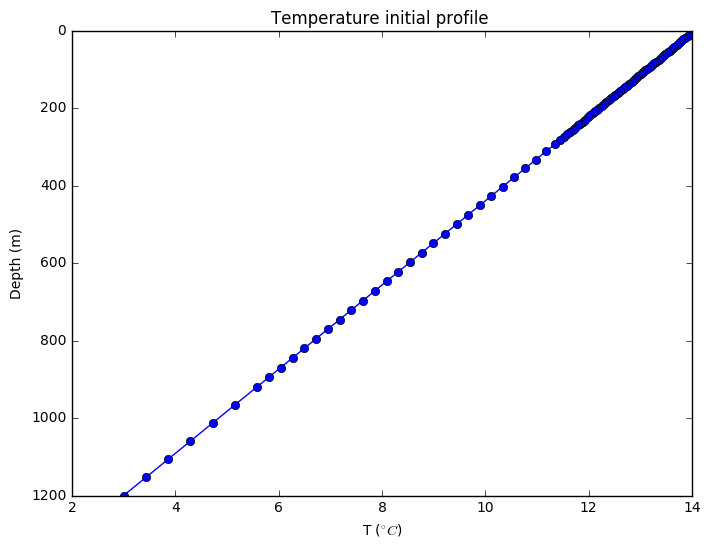

In [10]:
#Temperature

temp = [13.92419179,  10.19468641,   8.58686415,   7.45058646,
         7.28092498,   7.19139622,   6.92763903,   6.85987391,
         6.68035617,   6.11261289,   5.65138553,   5.30145515,
         4.94772486,   4.53669634,   4.17122877,   3.66913223,   3.21469724]  #Falkor Temp

#Temp=iniTracer(nx,ny,depth,temp,zi)
Temp = iniTracerLin(nx,ny,14.0,3.0,zi)

# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/Lintmp_N5p5_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Temp2 = Temp.transpose((2,0,1)) # To keep fortran order when writing as C binary
print(np.shape(Temp2))
Temp2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Temp[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('T ($^{\circ}C$)')
    
plt.ylabel('Depth (m)')
    
plt.title('Temperature initial profile ')



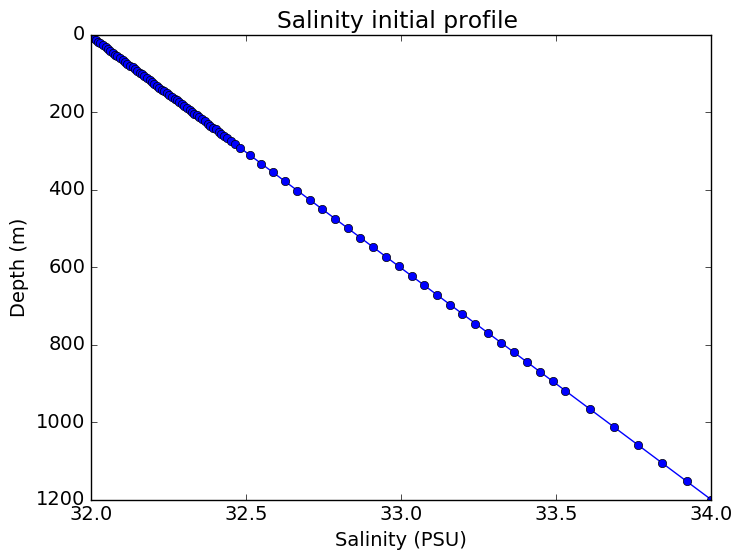

In [11]:
#Salinity

sal = [32.05565615,  32.47904982,  32.69883153,  33.14754095,
        33.45287546,  33.74755425,  33.89389881,  33.9139597 ,
        33.93728968,  33.98439263,  34.04611345,  34.09233602,
        34.14232788,  34.22413622,  34.28826251,  34.37998532,  34.4410795 ] #Falkor Salinity

#Sal = iniTracer(nx,ny,depth,sal,zi)
Sal = iniTracerLin(nx,ny,32.0,34.0,zi)

# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/Linsal_N5p5_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Sal2 = Sal.transpose((2,0,1)) # To keep fortran order when writing as C binarynp.asfortranarray(Sal)
Sal2.astype(dt).tofile(fileobj,"")
fileobj.close()

### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Sal[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Salinity (PSU)')
    
plt.ylabel('Depth (m)')
    

plt.title('Salinity initial profile ')



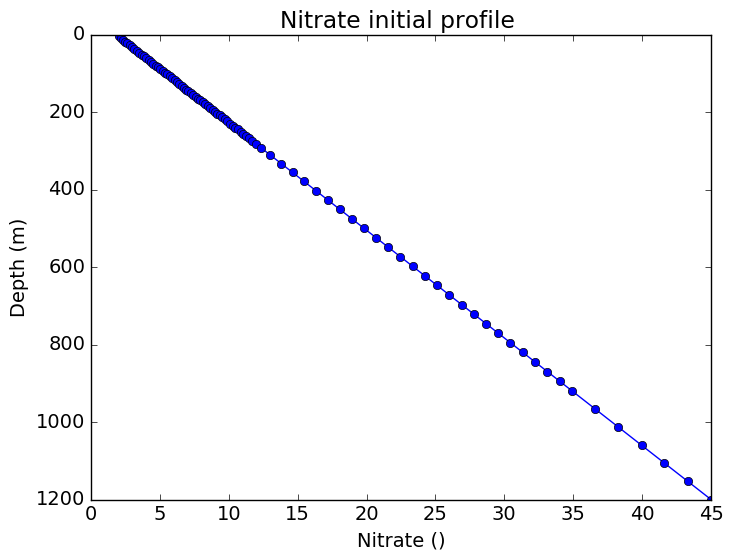

In [12]:
nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate

#Nitrate = iniTracer(nx,ny,depth,nit,zi)
Nitrate = iniTracerLin(nx,ny,2.0,45.0,zi)

               
# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/Linnit%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = Nitrate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Nitrate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Nitrate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Nitrate initial profile ')


In [13]:
for N,d in zip(depth,nit):
    print(N,d)

5.0 2.20769231
20.0 14.30606356
30.0 20.69884474
50.0 24.54682499
70.0 27.64221491
100.0 30.40401935
150.0 32.60791595
170.0 33.23055095
200.0 34.93009381
300.0 37.96639598
400.0 40.48248953
500.0 41.87936656
600.0 43.16092676
700.0 44.42630919
800.0 44.86319564
1000.0 45.33917039
1200.0 45.01343725


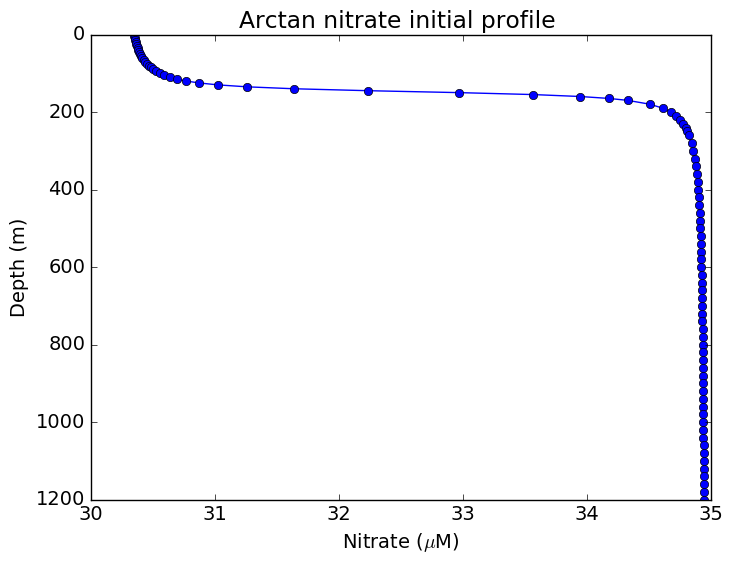

In [33]:
Csb = 32.6 #Falkor Nitrate at 150 m
Hs =147.5
a = 0.06
a_str = '06'

Nit_arctan = iniTracerArctan(nx,ny,a,Hs,Csb,np.array(zi))

               
# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/Arctan_nit_%s_%dzlev_%dx%d.bin" %(nx,ny,nz,a_str,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_arctan2 = Nit_arctan.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_arctan2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Nit_arctan[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel(r'Nitrate ($\mu$M)')
    
plt.ylabel('Depth (m)')
    

plt.title('Arctan nitrate initial profile ')


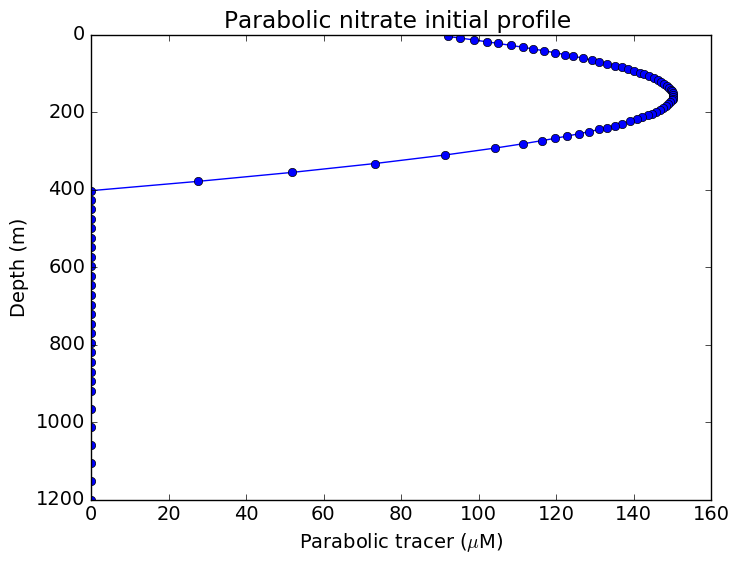

In [10]:
Co = 150.0#13.5  # To get positive profiles everywhere, arbitrary
Hs =147.5
C1 = 0.05
C2 = -2.5E-3 # 0.00, 0.00036 5.9e-05, -5.3e-05, -0.00029, 2.5E-3,-2.5E-3

a_str= 'Co_150_C1_0p05_C2_m2p5Em3'

Nit_arctan = iniTracerParabolic(nx,ny,Co,C1,C2,Hs,np.array(zi))

               
# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/Parab_tr_%s_%dzlev_%dx%d.bin" %(nx,ny,nz,a_str,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_arctan2 = Nit_arctan.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_arctan2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Nit_arctan[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel(r'Parabolic tracer ($\mu$M)')
    
plt.ylabel('Depth (m)')
    

plt.title('Parabolic nitrate initial profile ')


(360, 360, 90)
5 0.0
10 0.0
15 0.0
20 0.0
25 0.0
30 0.0
35 0.0
40 0.0
45 0.0
50 0.0
55 0.0
60 0.0
65 0.0
70 0.0
75 0.0
80 0.0
85 0.0
90 0.0
95 0.0
100 0.0
105 0.0
110 0.0
115 0.0
120 0.0
125 0.0
130 0.0
135 0.0
140 0.0
145 0.0
150 13.5
155 13.5
160 13.5
165 13.5
170 13.5
180 13.5
190 13.5
200 13.5
210 13.5
220 13.5
230 13.5
240 13.5
250 13.5
260 13.5
280 13.5
300 13.5
320 13.5
340 13.5
360 13.5
380 13.5
400 13.5
420 13.5
440 13.5
460 13.5
480 13.5
500 13.5
520 13.5
540 13.5
560 13.5
580 13.5
600 13.5
620 13.5
640 13.5
660 13.5
680 13.5
700 13.5
720 13.5
740 13.5
760 13.5
780 13.5
800 13.5
820 13.5
840 13.5
860 13.5
880 13.5
900 13.5
920 13.5
940 13.5
960 13.5
980 13.5
1000 13.5
1020 13.5
1040 13.5
1060 13.5
1080 13.5
1100 13.5
1120 13.5
1140 13.5
1160 13.5
1180 13.5
1200 13.5


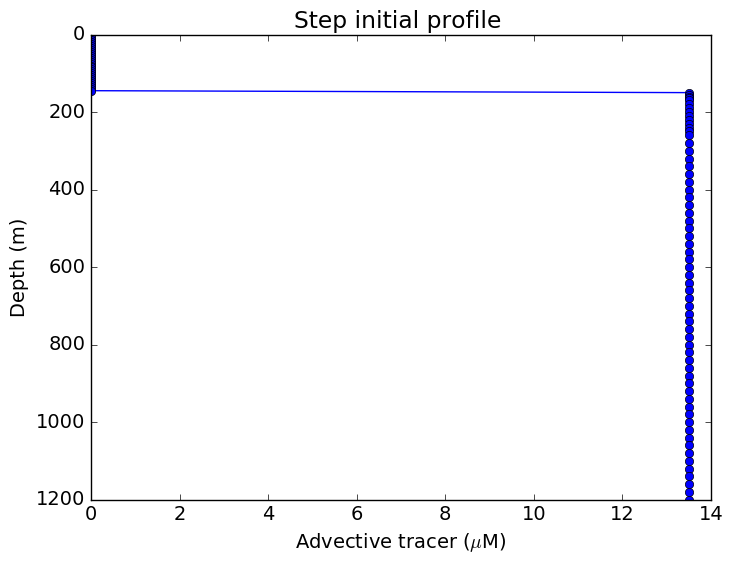

In [21]:
Cs = 13.5 # microM. Concentration at shelf break
topVal = 0.0 # fill in cocnetration at 0 above shelf break depth
Hs =150.0

Nit_arctan = iniTracerStep(nx,ny,topVal,Cs,Hs,np.array(zi))

# Save binary file
tmpfile = "%dx%dx%d/step_Hs13p5_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_arctan2 = Nit_arctan.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_arctan2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Nit_arctan[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel(r'Advective tracer ($\mu$M)')
    
plt.ylabel('Depth (m)')
    

plt.title('Step initial profile ')


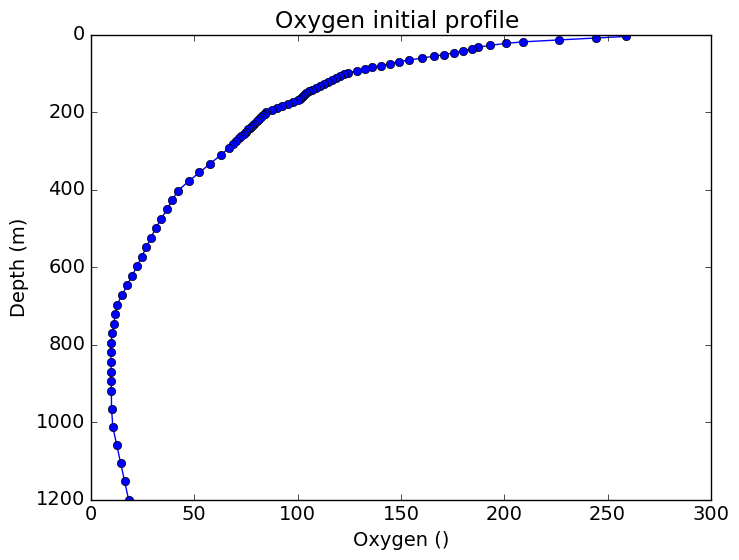

In [21]:
oxy = [ 258.64692308,  205.30523866,  189.93474682,  173.32762752,
        148.99494704,  123.39376698,  104.07073273,  100.34682448,
         84.75278265,   65.32870403,   42.38594405,   31.24731648,
         22.04183918,   12.32014822,    9.56728914,   10.02871031,
         18.18188635] #Falkor Oxygen

Oxygen = iniTracer(nx,ny,depth,oxy,zi)

# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/BCCoxy%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Oxygen2 = Oxygen.transpose((2,0,1)) # To keep fortran order when writing as C binary
Oxygen2.astype(dt).tofile(fileobj,"")
fileobj.close()        


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Oxygen[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Oxygen ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Oxygen initial profile ')




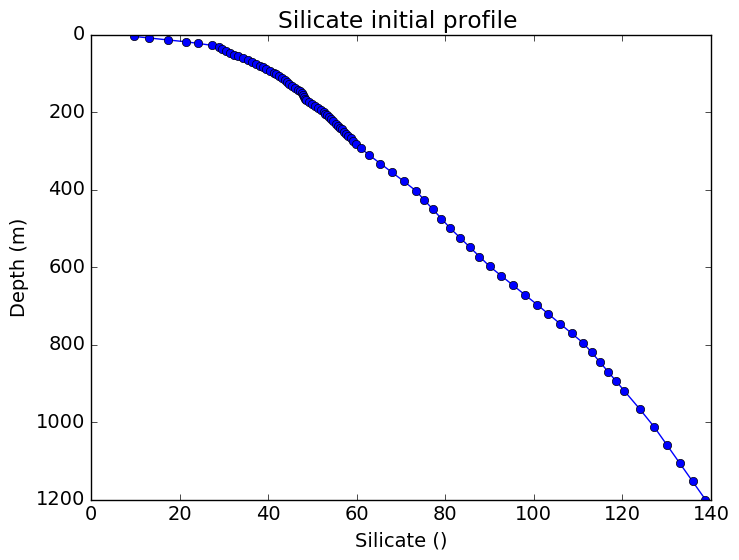

In [22]:
sil = [ 9.77487179,   22.40324386,   28.481157  ,   31.81179168,
         36.35084393,   41.51053289,   47.62601443,   48.57082304,
         52.54408413,   61.52273871,   73.08433615,   81.12181574,
         90.16770523,  101.05308596,  111.55221474,  126.39029233,
        138.72363852 ] #Falkor Silicate

Silicate = iniTracer(nx,ny,depth,sil,zi)

# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/BCCsil%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Silicate2 = Silicate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Silicate2.astype(dt).tofile(fileobj,"")
fileobj.close()              



### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Silicate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Silicate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Silicate initial profile ')



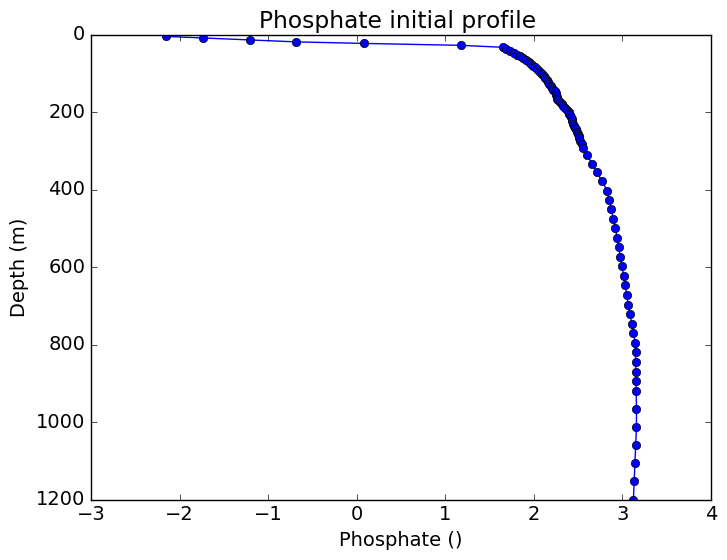

In [23]:
pho = [-2.14848718, -0.58315699,  1.6205616 ,  1.79738767,  1.94555393,
        2.08709737,  2.24576282,  2.27144092,  2.39342327,  2.57196961,
        2.82463189,  2.92081108,  2.99713342,  3.06841061,  3.14757836,
        3.16063801,  3.12403118  ] #Falkor Phosphate

Phosphate = iniTracer(nx,ny,depth,pho,zi)

               
# Save binary file
tmpfile = "%dx%dx%d_SmoothVertRes/BCCpho%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Phosphate2 = Phosphate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Phosphate2.astype(dt).tofile(fileobj,"")
fileobj.close()              



### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Phosphate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Phosphate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Phosphate initial profile ')



Let's check what we wrote...

In [25]:

fileNAME = "%dx%dx%d_SmoothVertRes/Lintmp_N5p5_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tempp=np.fromfile(fileNAME, dt)

In [26]:

temppp=np.reshape(tempp,(nx,ny,len(zi)),order='F')
np.shape(temppp)

(360, 360, 90)

In [27]:
print(max(tempp))


14.0


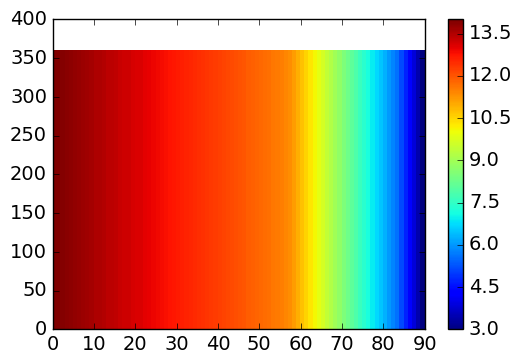

In [28]:
plt.pcolor(temppp[80,:,:])
plt.colorbar()

Generate horizontal tracer gradient file

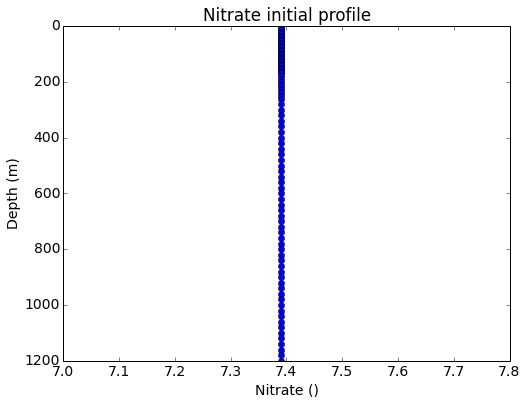

In [16]:
#Nitrate (from annual average)


nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate

nx = 360
nz = 90
ny = 360

yi = np.arange(ny)
#Nitrate = iniTracer(nx,ny,depth,nit,zi)
NitrateHor = iniTracerLinHor(nx,nz,2.0,45.0,yi)

               
# Save binary file
tmpfile = "%dx%dx%d/LinnitHor%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = NitrateHor.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(NitrateHor[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Nitrate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Nitrate initial profile ')

<matplotlib.colorbar.Colorbar instance at 0x7fc37234a368>

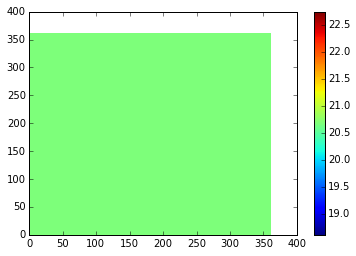

In [17]:
fileNAME = "%dx%dx%d/Lintmp_doubleN_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tempp=np.fromfile(fileNAME, dt)

temppp=np.reshape(tempp,(nx,ny,len(zi)),order='F')
np.shape(temppp)

plt.pcolor(temppp[:,:,40])
plt.colorbar()

/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


nan